In [400]:
import torch
import random
import numpy as np
from tqdm import tqdm
from clip import CLIPModel
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_from_disk
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

## Loading the tokenizer

In [401]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

## Load the trained model

In [402]:
# load saved model

loaded_model = torch.load("best_clip_model.pth")
model_params = loaded_model['model_params']

model = CLIPModel(**model_params)
model.load_state_dict(loaded_model['model_state_dict'])


/var/folders/v2/zm88qd750pz1379tn2s194q00000gn/T/ipykernel_18934/2030629695.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("best_clip_model.pt

<All keys matched successfully>

## Loading the test split

In [403]:
test_split = load_from_disk('test_split')
image_col = 'img'   
captions_col = 'text_EN'


## Create MCQ Dataset

In [404]:
class MCQImageTextDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, n_choices=5):
        self.dataset = hf_dataset
        self.transform = transform
        self.n_coises = n_choices
        tokenized_output = tokenizer(self.dataset[captions_col], padding='max_length', truncation=True, max_length=16, return_tensors='pt')
        self.caption_tokens = tokenized_output['input_ids']
        self.attention_mask = tokenized_output['attention_mask']



    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the image and the text label
        image = self.dataset[idx][image_col] 
        mask = self.attention_mask[idx]

        if np.array(image).shape[-1] != 3:
            image = self.dataset[0][image_col] 
            mask = self.attention_mask[0]

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)


        multiple_choice_idx = [random.randint(0, len(self.dataset)-1) for _ in range(self.n_coises-1)]

        if idx not in multiple_choice_idx:
            multiple_choice_idx.append(idx)

        else:
            last_idx = random.randint(0, len(self.dataset)-1)
            while last_idx in multiple_choice_idx:
                last_idx = random.randint(0, len(self.dataset)-1)
            multiple_choice_idx.append(last_idx)

        random.shuffle(multiple_choice_idx)

        truth_idx = multiple_choice_idx.index(idx)
        multiple_choice = torch.stack([self.caption_tokens[mc] for mc in multiple_choice_idx], dim=0)
        multiple_choice_idx = torch.tensor(multiple_choice_idx)

        # Return the image tensor and the text (or caption)
        return image, truth_idx, mask, multiple_choice, multiple_choice_idx

# Example transform (for images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),          # Convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (using ImageNet stats)
])

# Instantiate the custom dataset
hf_dataset = MCQImageTextDataset(test_split, transform=transform, n_choices=3)

# Create DataLoader for batching
dataloader = DataLoader(hf_dataset, batch_size=32, shuffle=False)

In [405]:
def predict_pair(image, multiple_choice):

    image = model.image_embeddings(image)
    image = model.image_encoder(image)
    image = model.image_ln_final(image)

    image_pooled = image[:, -1, :]
    image_pooled = model.image_projection(image_pooled)
    
    text_features = []
    for choice in multiple_choice:
        choice_features = model.encode_text(choice)
        text_features.append(choice_features)

    text_features = torch.stack(text_features, dim=0)
    predictions = []
    for image, multiple_choice in zip(image_pooled, text_features):
        # Normalize image and text features
        image = image / image.norm(dim=-1, keepdim=True)
        multiple_choice = multiple_choice / multiple_choice.norm(dim=-1, keepdim=True)
        score = image @ multiple_choice.T
        predicted_idx = torch.argmax(score)
        predictions.append(predicted_idx)
        
    return torch.tensor(predictions)


In [406]:
losses = []
model.eval()
model = model.to(device)
all_truth, all_predicted = [], []
for batch_idx, (images, truth_idx, masks, multiple_choice, multiple_choice_idx) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    captions = captions.to(device)
    masks = masks.to(device)
    multiple_choice = multiple_choice.to(device)

    with torch.no_grad():
        predicted_idx = predict_pair(images, multiple_choice).tolist()
        all_predicted.extend(predicted_idx.copy())

    all_truth.extend(truth_idx.tolist())

    if batch_idx == 0:
        visual_image = test_split[image_col][0:16]
        truth_caption = test_split[captions_col][0:16]
        all_choices = multiple_choice[0:16]
        
        predicted_idx = torch.tensor(predicted_idx).unsqueeze(1).unsqueeze(2).expand(-1, 1, 16).to(device)
        predicted_captions = torch.gather(multiple_choice, 1, predicted_idx).squeeze(1)
        predicted_captions = [tokenizer.decode(c,skip_special_tokens=True) for c in predicted_captions]
        

accuracy = sum([1 for p, t in zip(all_predicted, all_truth) if p == t]) / len(all_truth)
    

100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


In [407]:
accuracy

0.721

In [408]:
def decode_choices(choices):
    choices = choices.tolist()
    for i in range(len(choices)):
        for option in range(len(choices[0])):
            choices[i][option] = tokenizer.decode(choices[i][option], skip_special_tokens=True)
    return choices

choices = decode_choices(all_choices)

In [451]:
import matplotlib.patches as mpatches
def show_multiple_images_with_labels(images, labels_list, predictions, truth_captions, nrows=2, ncols=3):
    # Add the legend to the figure
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 7, nrows * 7))

    for idx, (img, label_choices, prediction, truth_caption) in enumerate(zip(images, labels_list, predictions, truth_captions)):
        ax = axs[idx // ncols, idx % ncols]  # Get the current axis based on index

        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide the axis

        # Define margin and starting y position for text in normalized figure coordinates
        margin = 0.05  # Margin below the image in axes coordinates
        text_start_y = -0.1  # Start slightly below the image

        # Display the three label choices and highlight the prediction
        for i, choice in enumerate(label_choices):
            if choice == truth_caption and choice == prediction:
                color = 'green'
            elif choice == prediction and choice != truth_caption:
                color = 'red'
            else:
                color = 'black'
            
            choice = '--> ' + choice if choice == truth_caption else choice
            ax.text(
                0.5,                         # Center the text horizontally
                text_start_y - i * 0.05,     # Position text vertically below the image
                choice, 
                fontsize=14, 
                color=color, 
                transform=ax.transAxes,      # Use axes coordinates (normalized)
                ha='center',                 # Horizontal alignment in the center
                va='top',                    # Vertical alignment for top of text
                wrap=True
            )
    correct_patch = mpatches.Patch(color='green', label='Correct Prediction')
    incorrect_patch = mpatches.Patch(color='red', label='Incorrect Prediction')
    fig.legend(handles=[correct_patch, incorrect_patch], loc='upper right', fontsize=12)

    # Adjust the layout to ensure everything fits
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.suptitle('Images and and Predicted Captions', fontsize=20)
    plt.show()


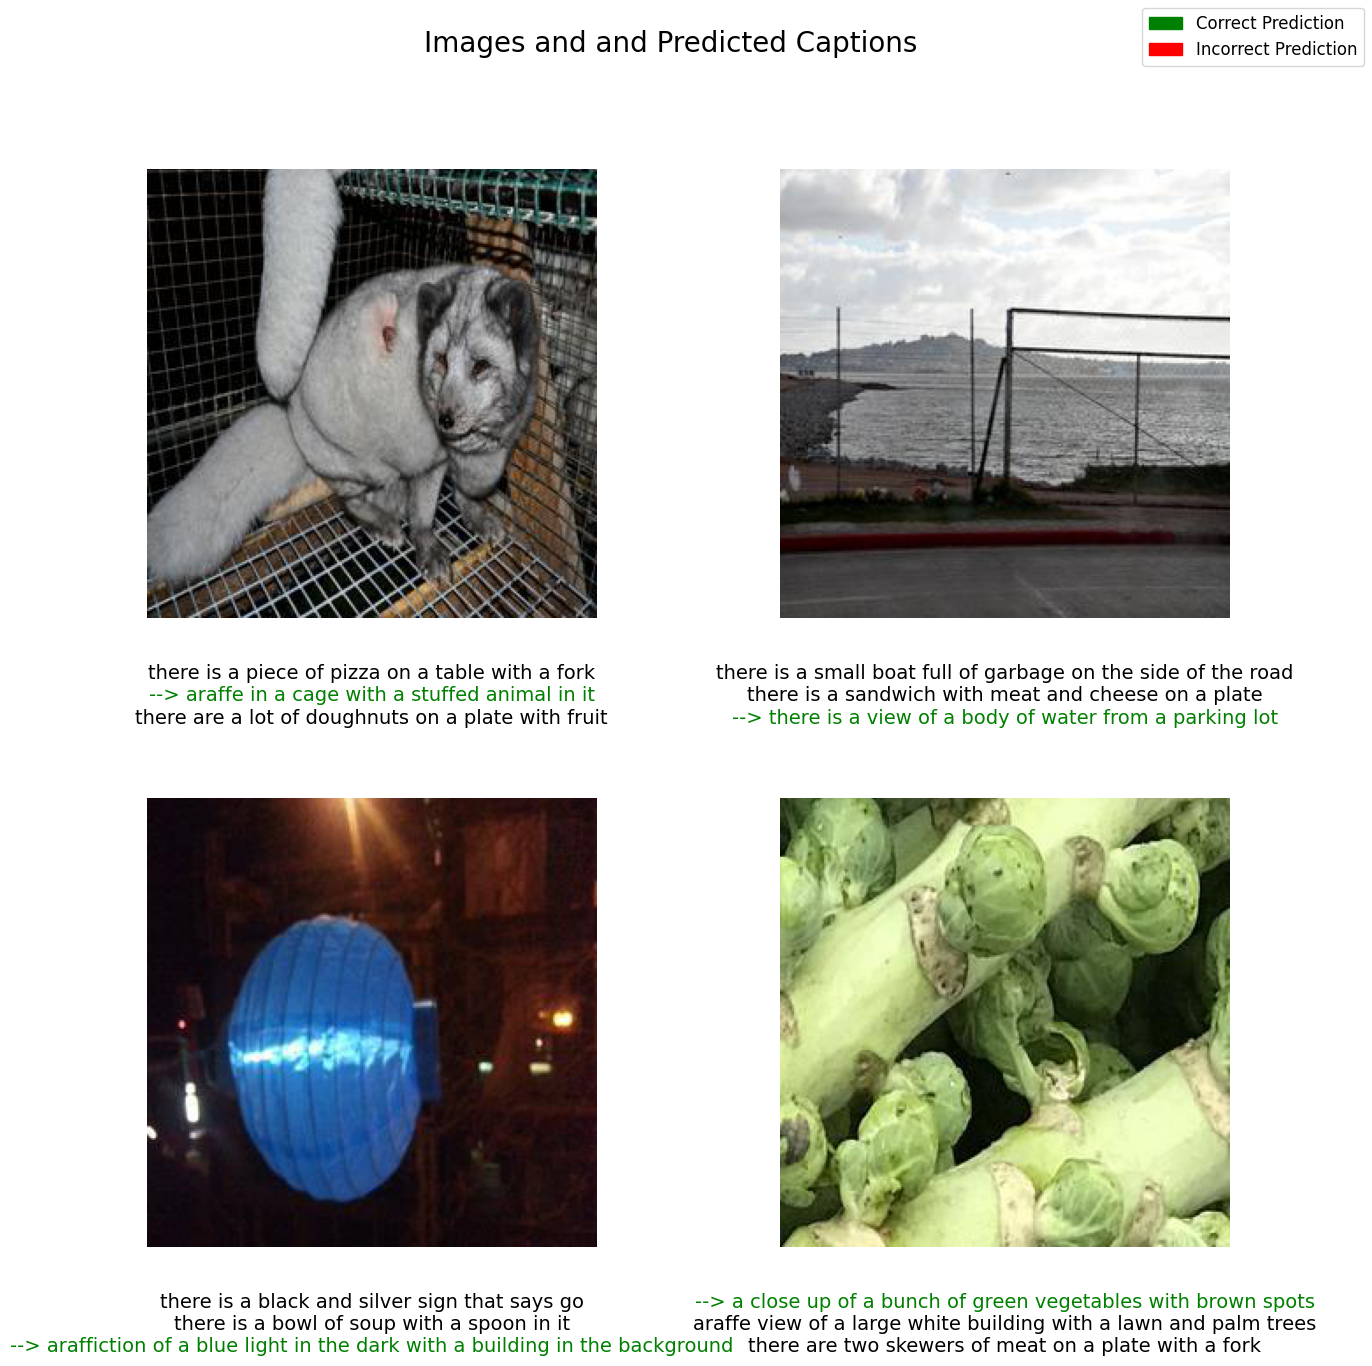

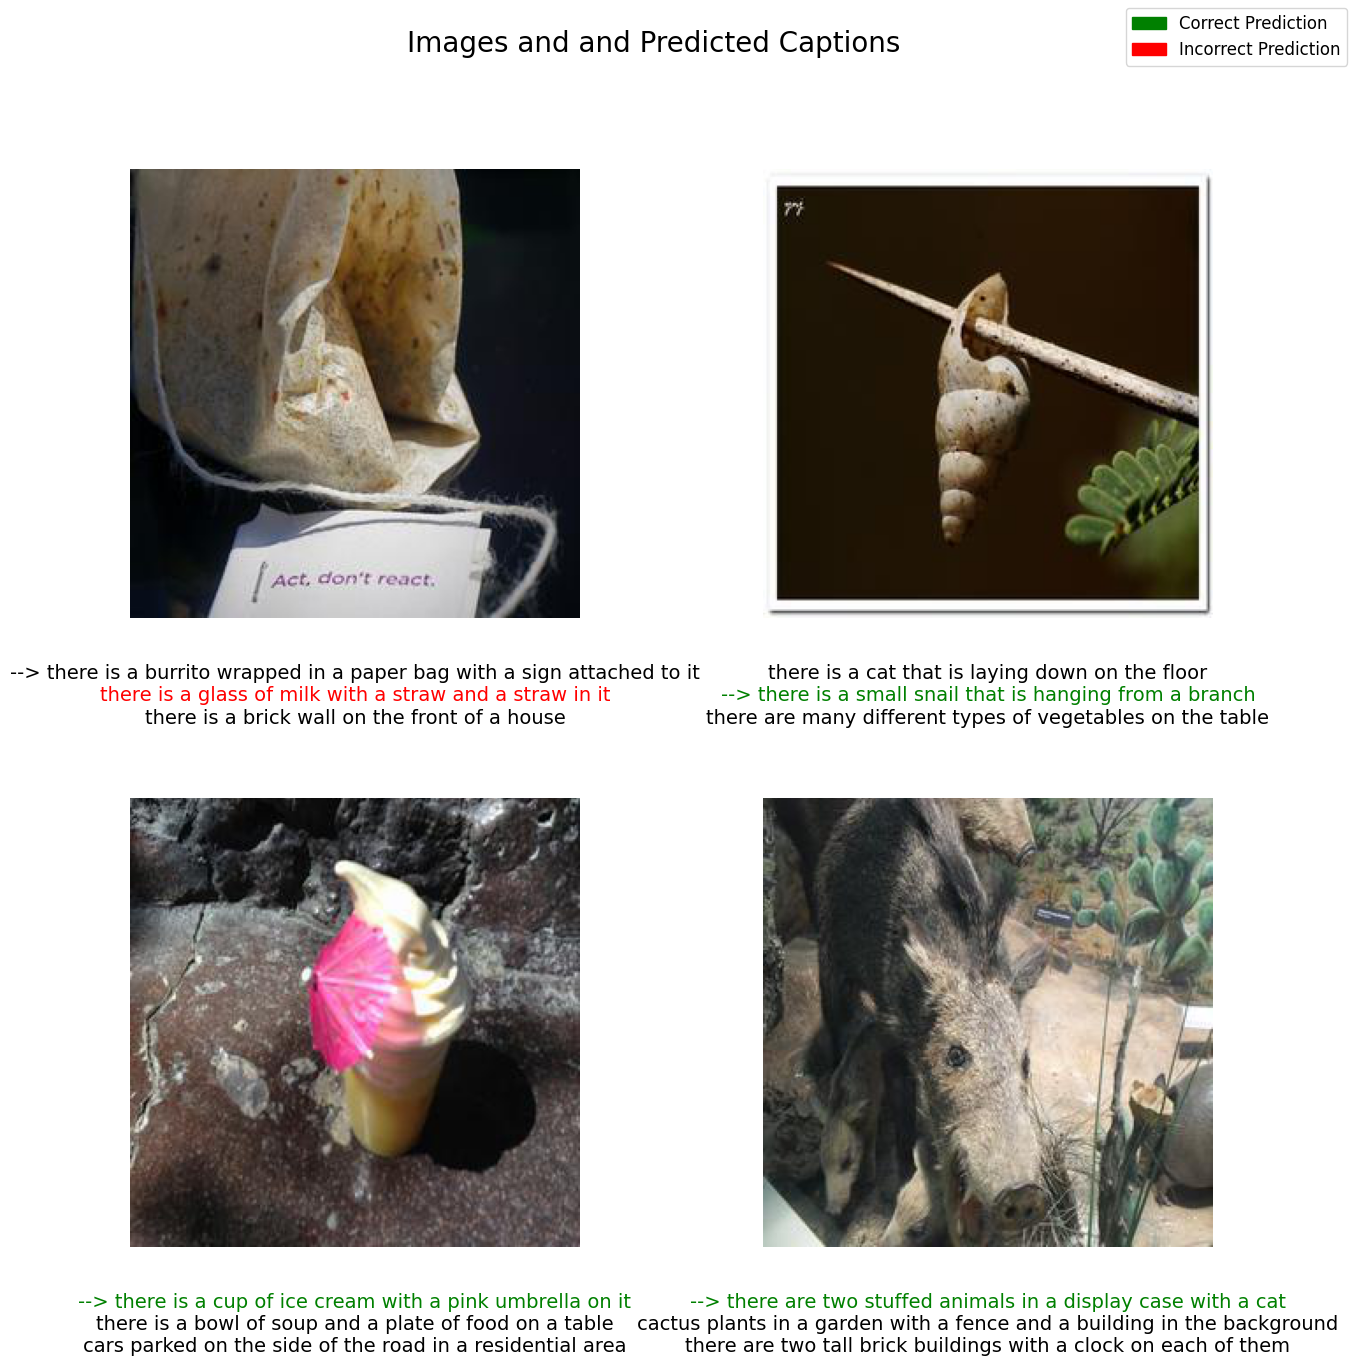

In [454]:
for i in [0, 4]:
    show_multiple_images_with_labels(visual_image[i:i+4], choices[i:i+4], predicted_captions[i:i+4], truth_caption[i:i+4], ncols=2, nrows=2)